### Pre-Processing

In [64]:
import pickle
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
import seaborn as sns
import datetime as datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar
% matplotlib inline

#### Create Custom list of stop words

Besides the stop words given in two stop word lists, I wanted to also exclude some random that were coming out in my initial topic models. 

In [2]:
random_words = ["miss", "mr", "mrs", "said", "jr", "ms"]
nytimes_words = ["photo", "nytimes", "nytoday", "com"]
trump_name = ["trump", "donald"]
custom_words = "___ saying told news party people like political new going candidate time think nominee speech _____ briefing evening posted eastern want email weekend stories weekdays sundays rundown nightly latest look 10 morning 11 sign let obama country national convention week american year say house york make know states monday day colbert late stephen letterman comedy host cbs report character theater guest night jon central sullivan played taping network stewart ed"
custom_words_list = custom_words.split()

In [4]:
STOPLIST = set(stopwords.words('english') + random_words + list(ENGLISH_STOP_WORDS) + 
               nytimes_words + trump_name + custom_words_list)
STOPLIST = list(STOPLIST)

#### Finalize Dataset 

In [5]:
with open("Trump_Clinton_dataset.pkl", 'r') as picklefile: 
    merged_data = pickle.load(picklefile)

I only want news articles that had some version of Trump as a key word

In [175]:
merged_data["Type"].unique()

array([u'Video', u'Interactive Feature', u'Op-Ed', u'News', u'Slideshow',
       u'Blog', u'Editorial', u'Letter; Editorial',
       u'An Analysis; News Analysis', u'Schedule', u'Review', u'Obituary',
       u'Brief', u'Letter', u'briefing', u'Quote', u'Question',
       u'Special Report', u'Text', u'Paid Death Notice', u'An Analysis',
       u'Biography', u'List', None, u'Interview', u'Op-Ed; Editorial',
       u'Correction', u'Newsletter'], dtype=object)

In [6]:
news_only = merged_data[merged_data["Type"] == "News"]
trump_names = ["trump", "donald", "trumps", "donalds"]
trump_pattern = '|'.join(trump_names)
news_only["Keywords_as_string"] = news_only["Keywords"].apply(lambda x: ' '.join(x))
news_only["Trump_Keyword"] = news_only["Keywords_as_string"].str.contains(trump_pattern)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [57]:
Trump_Only = news_only[news_only["Trump_Keyword"] == True]
Trump_Only = Trump_Only.drop_duplicates("Text")

There are multiple date columns and I wanted to create one that has the month and year

In [58]:
Trump_Only["Best_Date"] = Trump_Only["Pub_Date"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())

In [186]:
len(Trump_Only)

2196

### Topic Modeling with TFIDF and NMF

In [50]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.4, min_df = 15,
                                   stop_words = STOPLIST)
tfidf = tfidf_vectorizer.fit_transform(Trump_Only["Text_Clean"])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
nmf = NMF(n_components = 30, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)

In [51]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [52]:
transformed_data = nmf.transform(tfidf)
len(transformed_data)

2196

In [53]:
print_top_words(nmf, tfidf_feature_names, 20)

Topic #0:
years women america media good called times united friday world way immigration asked group policy long right city americans democrats
Topic #1:
cruz rubio ted kasich conservative texas marco primary south debate roe iowa establishment carolina wisconsin values saturday conservatives vote indiana
Topic #2:
sanders bernie primary supporters tuesday california victory vermont democrats superdelegates nomination fight general philadelphia primaries kentucky defeat young november votes
Topic #3:
tax income returns taxes rate plan percent trillion release rates economic deductions revenue pay cuts federal lower business care corporate
Topic #4:
ryan speaker nehlen paul wisconsin agenda endorse priebus endorsement congressional policy district senate primary gop washington majority tuesday representative sen
Topic #5:
ad ads pac advertising super narrator priorities million supporting usa spent takeaway group screen television message commercial women negative pacs
Topic #6:
pence 

### Create a long-form dataset with the following columns: Month-Year (e.g. June 2016), Topic Number, Topic Name, and Number of Articles with that topic in that month

In [54]:
def zero_equals_1(x): 
    if x != 0:
        return 1
    else:
        return x

In [286]:
type(melted_df["Month_Year"][2196])

str

In [290]:
May_2016 = melted_df[(melted_df["Month_Year"]) == "May 2016"]

In [294]:
May_T16 = May_2016[(May_2016["Topic_Num"] == 16) & (May_2016["value"] == 1.0)]

In [295]:
May_T16

,Article_Num,Date,Topic_Num,value,Month_Year
35565,430,2016-05-12,16,1.0,May 2016
35588,453,2016-05-06,16,1.0,May 2016
35590,455,2016-05-08,16,1.0,May 2016
35598,463,2016-05-05,16,1.0,May 2016
35669,534,2016-05-30,16,1.0,May 2016
36881,1746,2016-05-12,16,1.0,May 2016
36887,1752,2016-05-11,16,1.0,May 2016


In [304]:
transformed_data.ix[429, 16]

0.28659005124919257

In [303]:
Trump_Only.ix[429, :]

index                                                              8248
Authors                               [Steven Erlanger, Stephen Castle]
Date                                                2016-05-12 00:00:00
Date_x                                                              NaT
Date_y                                                              NaT
Headline              {u'main': u'Sadiq Khan, London’s Muslim Mayor,...
Keywords              [londons, america, khan, trump, calls, muslim,...
Month                                                               NaN
Pub_Date                                           2016-05-12T00:00:00Z
Section_name                                                      World
Summary               Mr. Trump is “playing into the hands of extrem...
Text                  Photo\n\nLONDON — The new mayor of London, Sad...
Text_Clean            Photo  LONDON — The new mayor of London, Sadiq...
Text_Decode           Photo\n\nLONDON — The new mayor of London,

In [308]:
Trump_Only.ix[1745, :]

index                                                             10252
Authors                                              [Vanessa Friedman]
Date                                                                NaT
Date_x                                              2016-05-12 00:00:00
Date_y                                              2016-05-12 00:00:00
Headline              {u'main': u'Trump vs. the Disappearing Tie', u...
Keywords              [party, president, khan, trump, political, tsi...
Month                                                                 5
Pub_Date                                           2016-05-12T00:00:00Z
Section_name                                            Fashion & Style
Summary               Call it Phase 3 of political dress evolution.\...
Text                  As it happens, neither did Mr. Xi, Vice Presid...
Text_Clean            As it happens, neither did Mr. Xi, Vice Presid...
Text_Decode           As it happens, neither did Mr. Xi, Vice Pr

In [59]:
transformed_data = pd.DataFrame(transformed_data)
article_topics = transformed_data.applymap(zero_equals_1)
Trump_Only = Trump_Only.reset_index()
article_topics["Date"] = Trump_Only["Best_Date"]
article_topics["Article_Num"] = range(1, len(article_topics) + 1)
melted_df = pd.melt(article_topics, id_vars = ["Article_Num", "Date"], var_name = "Topic_Num")

Make a column with the month and the year

In [62]:
def extract_month_year(date):
    month = date.month
    month_name = calendar.month_name[month]
    year = date.year
    return month_name + " " + str(year)

In [65]:
melted_df["Month_Year"] = melted_df["Date"].apply(lambda x: extract_month_year(x))

In [69]:
melted_df.groupby("Topic_Num").sum().sort_values("value").reset_index()

,Topic_Num,Article_Num,value
0,29,2412306,74.0
1,13,2412306,83.0
2,23,2412306,88.0
3,10,2412306,99.0
4,19,2412306,101.0
5,21,2412306,102.0
6,27,2412306,113.0
7,16,2412306,146.0
8,6,2412306,160.0
9,20,2412306,161.0


All topics have a decent number of articles covering them

I need to get rid of the "nonsense" topics that I can't interpret, as there's no point in graphing them. 

In [71]:
melted_df = melted_df[-melted_df["Topic_Num"].isin([0, 26])]

### Assign Names to Topics

In [70]:
print_top_words(nmf, tfidf_feature_names, 20)

Topic #0:
years women america media good called times united friday world way immigration asked group policy long right city americans democrats
Topic #1:
cruz rubio ted kasich conservative texas marco primary south debate roe iowa establishment carolina wisconsin values saturday conservatives vote indiana
Topic #2:
sanders bernie primary supporters tuesday california victory vermont democrats superdelegates nomination fight general philadelphia primaries kentucky defeat young november votes
Topic #3:
tax income returns taxes rate plan percent trillion release rates economic deductions revenue pay cuts federal lower business care corporate
Topic #4:
ryan speaker nehlen paul wisconsin agenda endorse priebus endorsement congressional policy district senate primary gop washington majority tuesday representative sen
Topic #5:
ad ads pac advertising super narrator priorities million supporting usa spent takeaway group screen television message commercial women negative pacs
Topic #6:
pence 

In [102]:
topic_num_to_name = {1: "Republican Primary 1", 
                     2: "Democratic Primary", 
                     3: "Economy",
                     4: "Republicans",
                     5: "Campaign Spending 1", 
                     6: "Vice President Choice" ,
                     7: "Republican Primary 2", 
                     8: "Polling",
                     9: "Fox News Debates",
                     10: "Trump Campaign",
                     11: "Police",
                     12: "Republic Primary 3",
                     13: "Polling 2",
                     14: "Foreign Policy",
                     15: "Russia",
                     16: "Khan Family",
                     17: "Republican Primary 4",
                     18: "Republican Primary 5",
                     19: "Michael Bloomberg",
                     20: "Trump University Lawsuit",
                     21: "Democrats and Trump",
                     22: "Guns",
                     23: "Democrat Vice President",
                     24: "Trump Campaign 2",
                     25: "Supreme Court",
                     27: "Trump Casinos",
                     28: "Campaign Spending 2",
                     29: "Miss America"}

In [103]:
topic_num_to_name = pd.DataFrame.from_dict(topic_num_to_name, orient = "index").reset_index()
topic_num_to_name.columns = ["Topic_Num", "Topic_Name"]
final_df = melted_df.merge(topic_num_to_name, on = "Topic_Num")

### Put Topics into Groups for Plotting

In [104]:
overall_topics = pd.DataFrame({"Primaries": [1, 2, 7, 9, 12, 17, 18, "NaN", "NaN", "NaN"], 
                               "Policies": [3, 11, 14, 15, 22, "NaN", "NaN", "NaN", "NaN", "NaN"], 
                              "Post-Primary Campaign": [4, 5, 6, 8, 10, 13, 21, 23, 24, 28], 
                               "Other": [16, 19, 20, 26, 27, 29, "NaN", "NaN", "NaN", "NaN"]})
melted_ot = pd.melt(overall_topics)
melted_ot = melted_ot[melted_ot["value"] != "NaN"]
melted_ot.columns = ["Overall Topic", "Topic_Num"]

In [105]:
final_df = final_df.merge(melted_ot, on = "Topic_Num")

In [112]:
final_df = final_df.groupby(["Month_Year", "Topic_Num", "Topic_Name", "Overall Topic"]).sum().reset_index()

In [116]:
final_df = final_df.rename(columns={'Topic_Name': 'Topic Name'})

## Plot Trump Article Topics over Time for each Group of Topics

In [106]:
 order = ["June 2015", "July 2015", "August 2015", "September 2015", "October 2015",
          "November 2015", "December 2015", "January 2016", "February 2016", 
          "March 2016", "April 2016", "May 2016", "June 2016", "July 2016", "August 2016"]

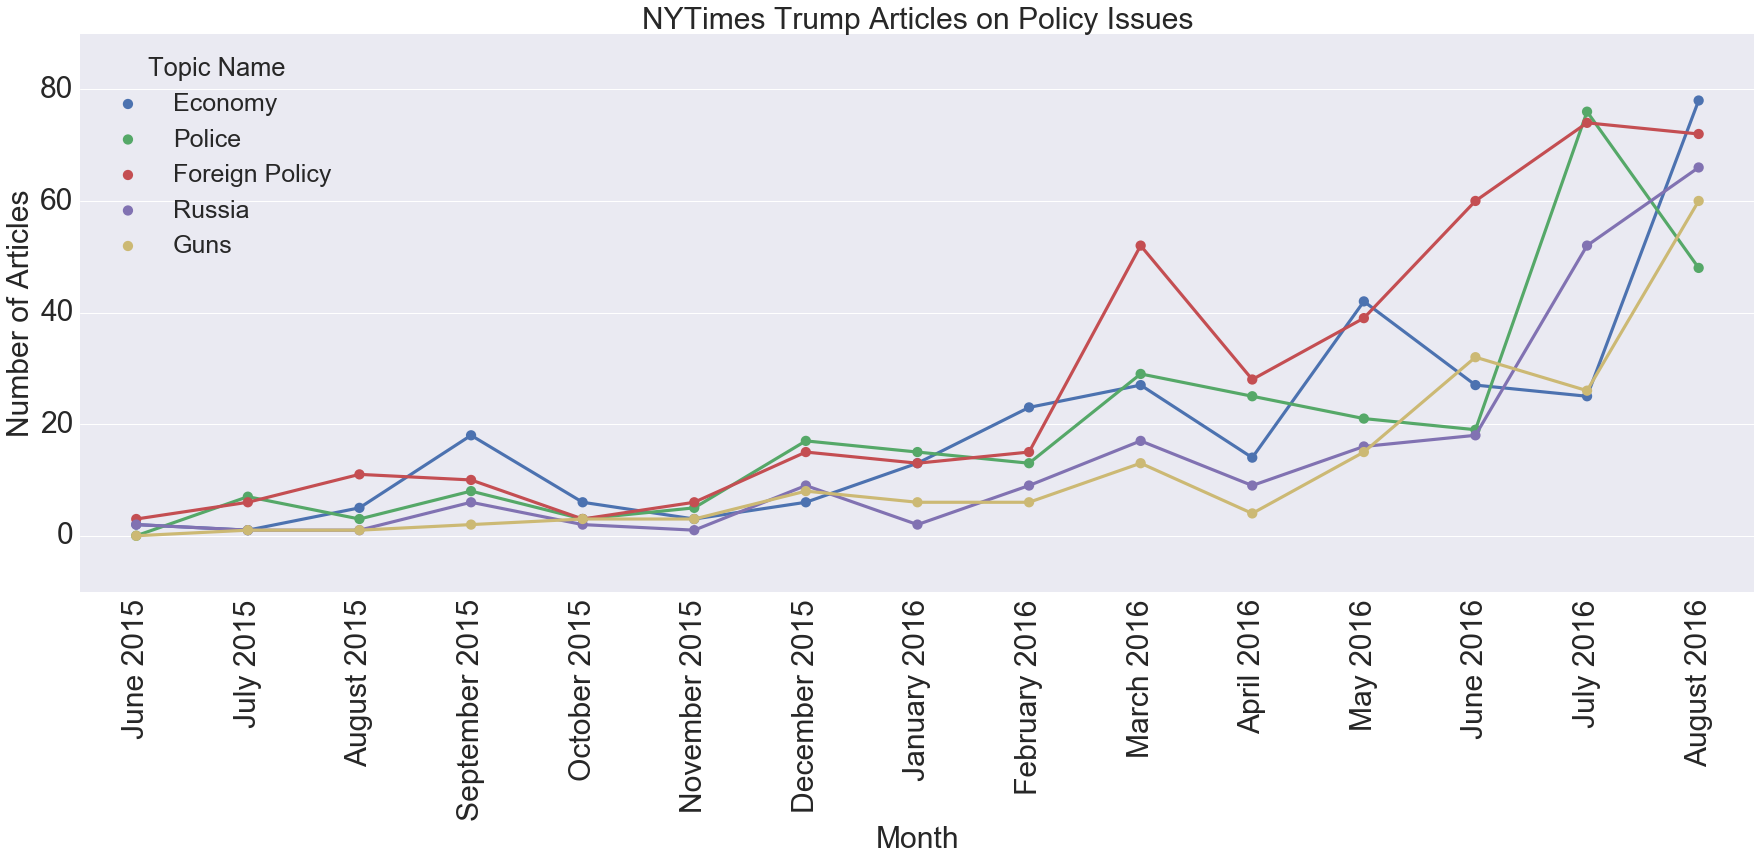

In [129]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 30, 'legend.fontsize': 25.0, 'axes.titlesize': 30, "figure.figsize": [30, 10]}
sns.set(rc=rc)
one_topic = final_df[final_df["Overall Topic"] == "Policies"]
g = sns.pointplot(ci = None, x = one_topic["Month_Year"], y = one_topic["value"], order = order, hue = one_topic["Topic Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Month", ylabel = "Number of Articles", title = "NYTimes Trump Articles on Policy Issues")
plt.savefig("Policy_Articles.png", bbox_inches='tight')

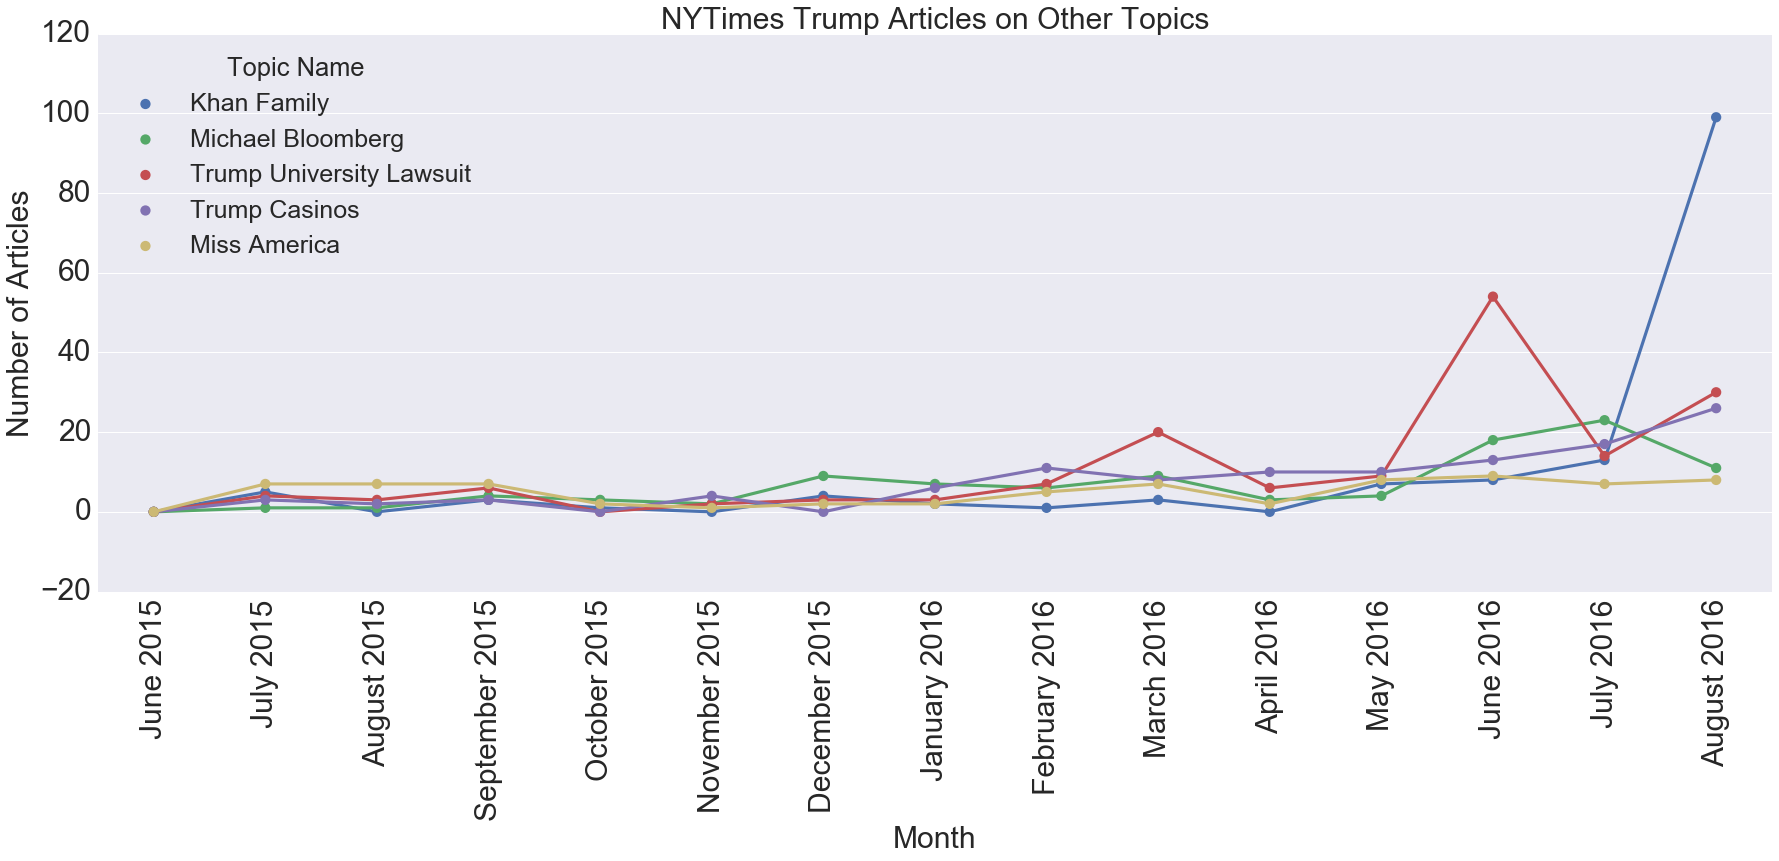

In [130]:
sns.set(rc=rc)
one_topic = final_df[final_df["Overall Topic"] == "Other"]
g = sns.pointplot(ci = None, x = one_topic["Month_Year"], y = one_topic["value"], order = order, hue = one_topic["Topic Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Month", ylabel = "Number of Articles", title = "NYTimes Trump Articles on Other Topics")
plt.savefig("Other_Articles.png", bbox_inches='tight')

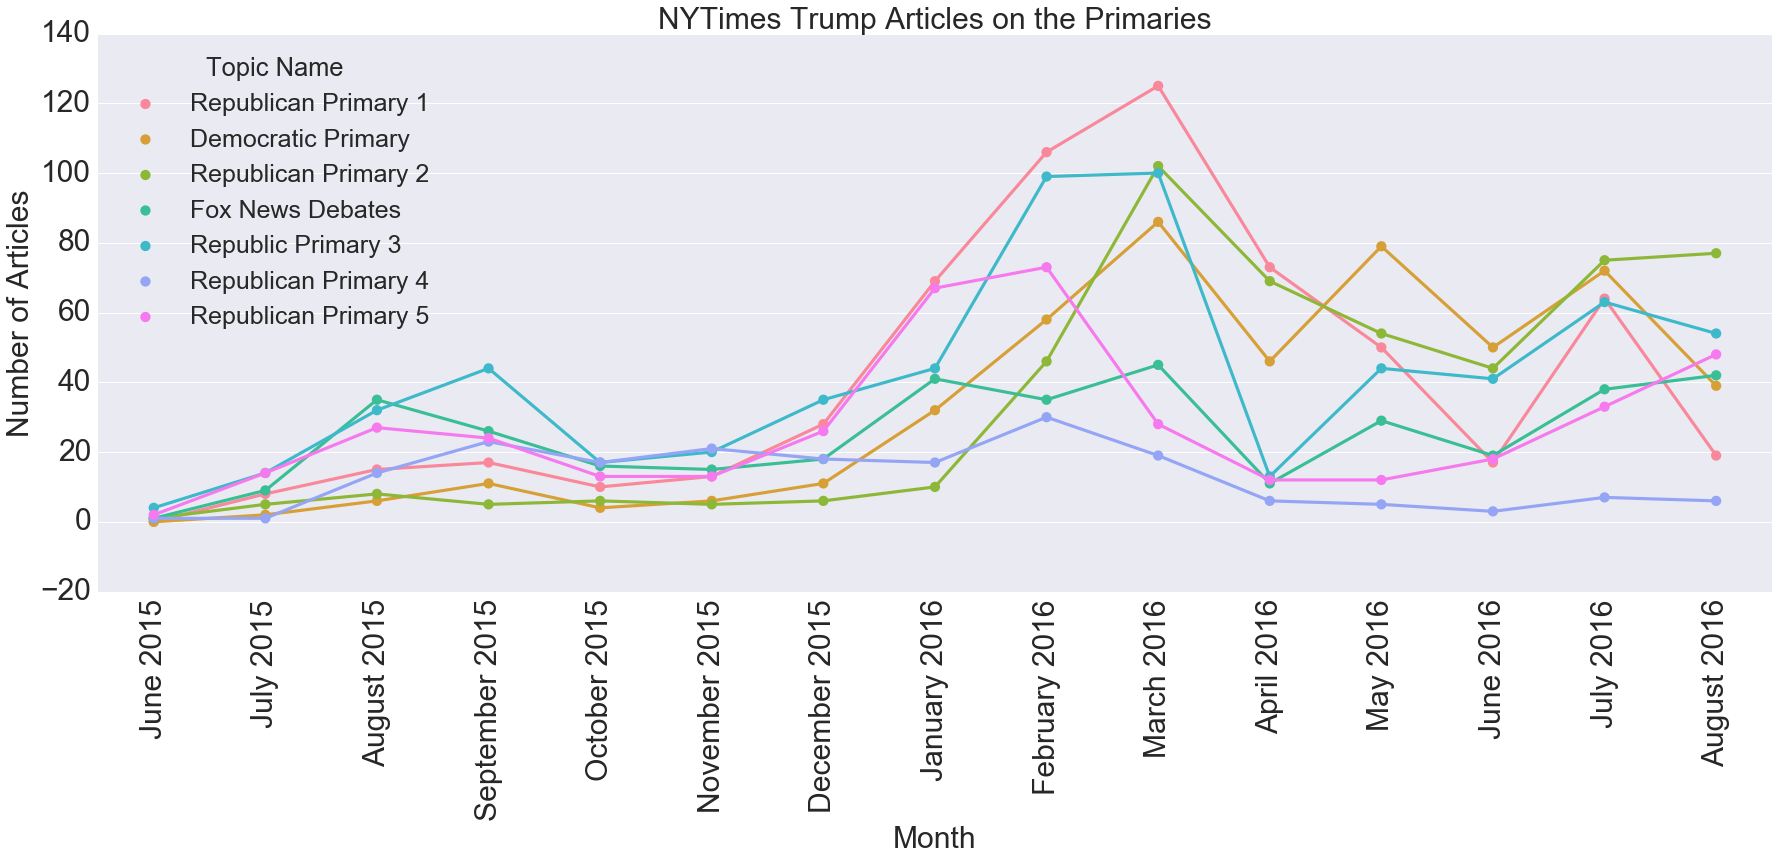

In [126]:
sns.set(rc=rc)
one_topic = final_df[final_df["Overall Topic"] == "Primaries"]
g = sns.pointplot(ci = None, x = one_topic["Month_Year"], y = one_topic["value"], order = order, hue = one_topic["Topic Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Month", ylabel = "Number of Articles", title = "NYTimes Trump Articles on the Primaries")

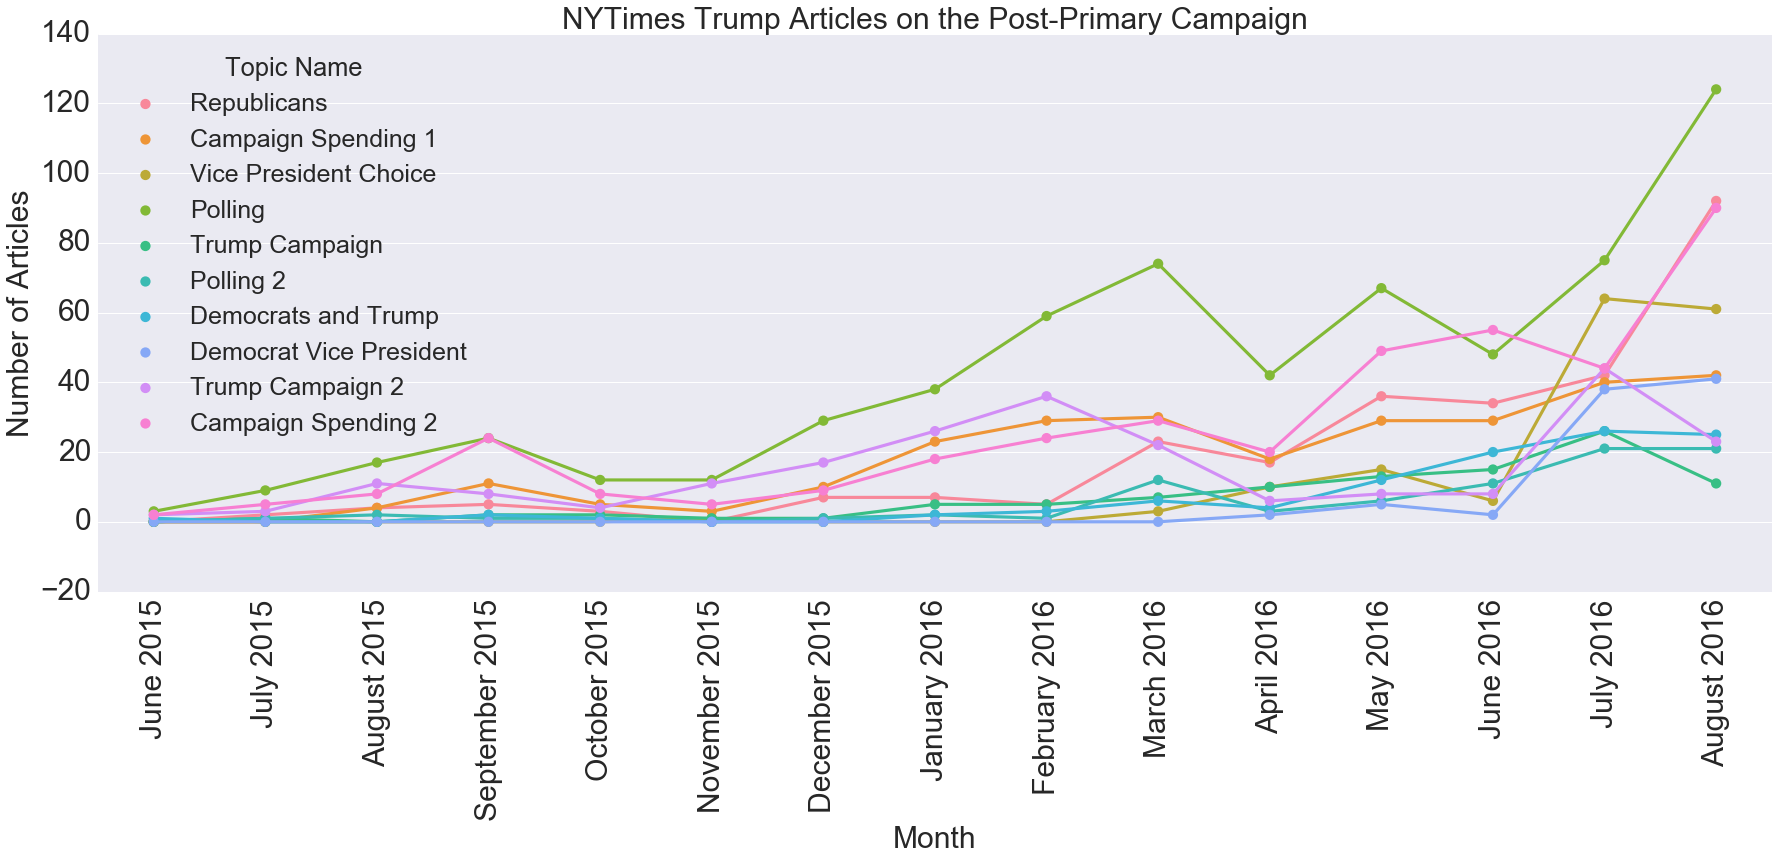

In [128]:
one_topic = final_df[final_df["Overall Topic"] == "Post-Primary Campaign"]
g = sns.pointplot(ci = None, x = one_topic["Month_Year"], y = one_topic["value"], order = order, hue = one_topic["Topic Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Month", ylabel = "Number of Articles", title = "NYTimes Trump Articles on the Post-Primary Campaign")

In [142]:
Trump_Only["Month_Year"] = Trump_Only["Best_Date"].apply(lambda x: extract_month_year(x))
Count_by_Month = Trump_Only.groupby("Month_Year").size().reset_index()
Count_by_Month.columns = ["Month", "Number of Articles"]

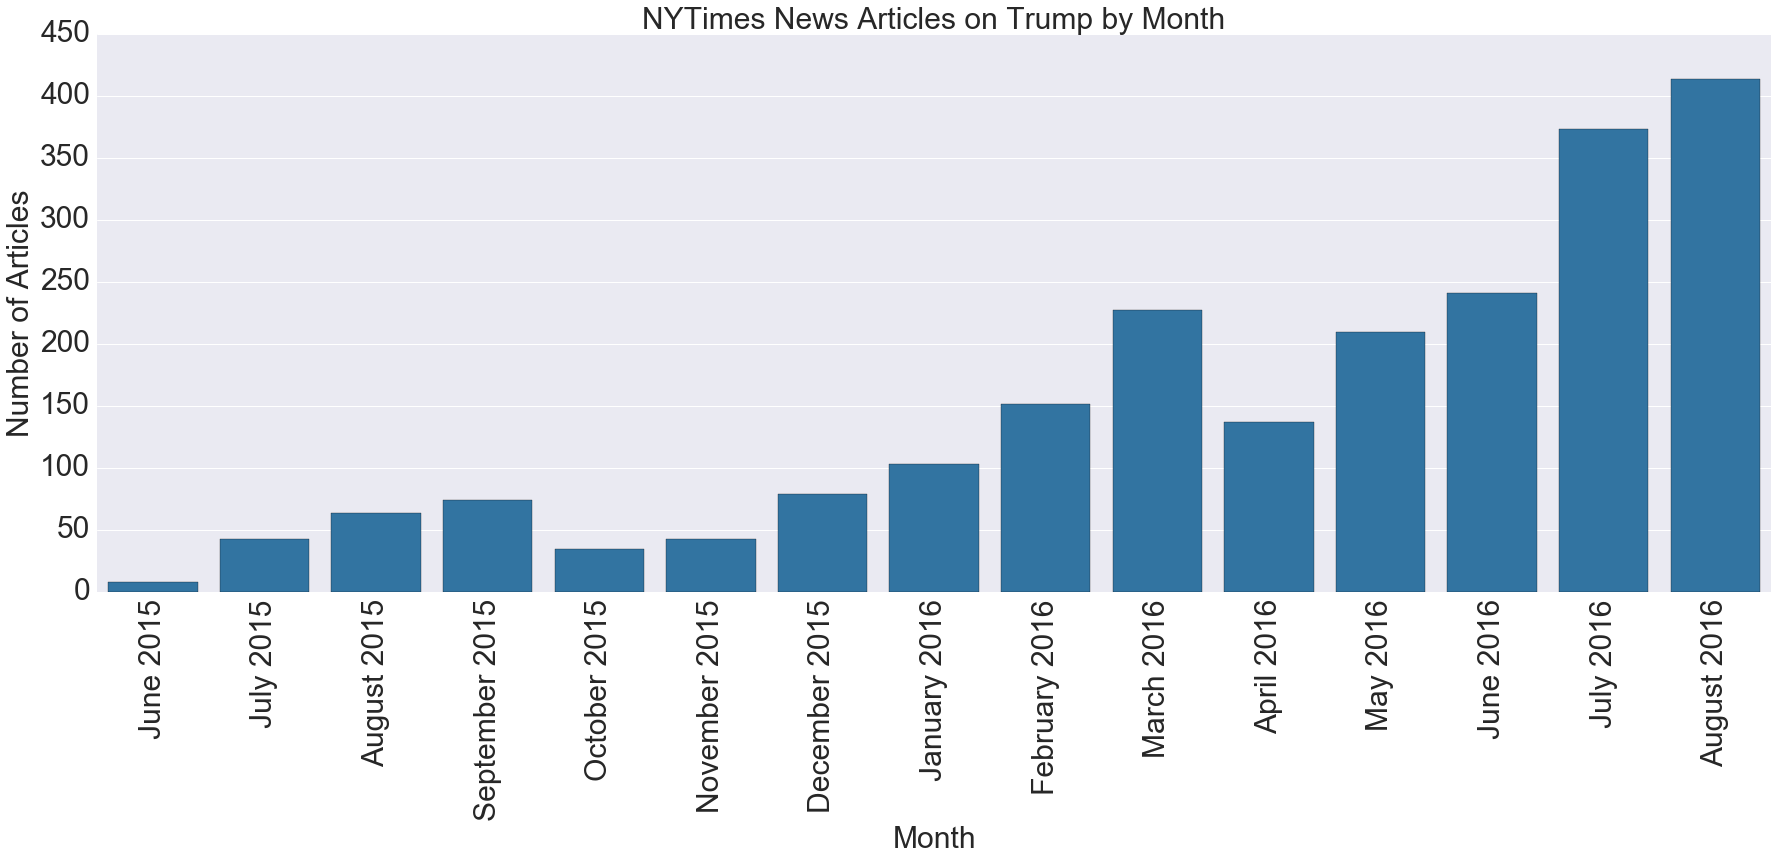

In [168]:
g = sns.barplot(data = Count_by_Month, x = "Month", y = "Number of Articles", order = order, color = (31 / 255., 119 / 255., 180 / 255.))
plt.xticks(rotation=90)
g.set(ylabel = "Number of Articles", title = "NYTimes News Articles on Trump by Month")
plt.savefig("Article_Num_by_Month.png", bbox_inches='tight')

### Graph on Mix of Topics

In [180]:
mixed_topics = final_df[final_df["Topic Name"].isin(["Khan Family", "Trump University Lawsuit", "Republican Primary 1", "Polling"])]

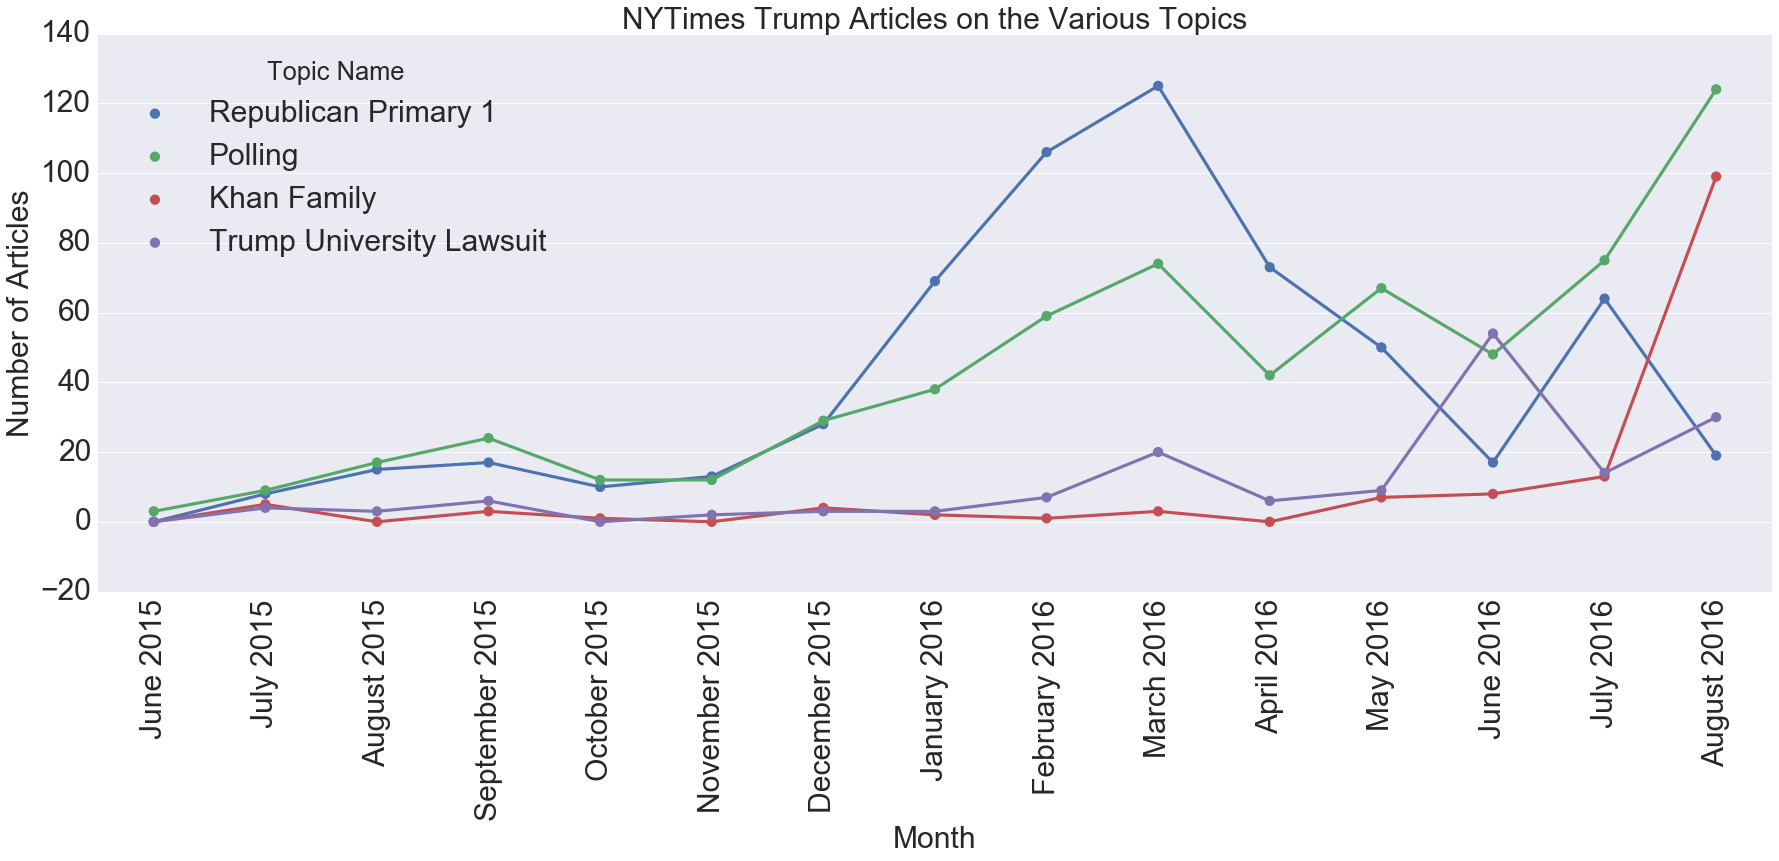

In [185]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 30, 'legend.fontsize': 30.0, 'axes.titlesize': 30, "figure.figsize": [30, 10]}
sns.set(rc=rc)
g = sns.pointplot(ci = None, x = mixed_topics["Month_Year"], y = mixed_topics["value"], order = order, hue = mixed_topics["Topic Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Month", ylabel = "Number of Articles", title = "NYTimes Trump Articles on the Various Topics")
plt.savefig("Various_Topics.png", bbox_inches='tight')

### MongoDB Practice

In [309]:
from pymongo import MongoClient
import json
records = json.loads(final_df.T.to_json()).values()
final_dataset = db.final_dataset
for record in records:
    final_dataset_id = final_dataset.insert_one(record).inserted_id

In [310]:
final_dataset.find_one({"Month_Year": "August 2015"})

{u'Article_Num': 57822,
 u'Month_Year': u'August 2015',
 u'Overall Topic': u'Post-Primary Campaign',
 u'Topic Name': u'Polling 2',
 u'Topic_Num': 13,
 u'_id': ObjectId('57b70e4c97f6b38765d395c1'),
 u'value': 2.0}